# Nino calculations

In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
# set up plotting settings for dark mode.
from jupyterthemes import jtplot
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=False)
from src.plot_utils import ps_defaults
ps_defaults(use_tex=False, dpi=150)

## Introduction
https://ncar.github.io/PySpark4Climate/tutorials/Oceanic-Ni%C3%B1o-Index/
This notebook will introduce El Niño Index Calculation using PySpark to parallelize a number of tasks like computation of monthly averages for a given grid chunk, etc.

NOAA's operational definitions of El Niño and La Niña conditions are based upon the Oceanic Niño Index [ONI]. The ONI is defined as the 3-month running means of SST anomalies in the Niño 3.4 region [5N-5S, 120-170W].

The ONI is one measure of the El Niño-Southern Oscillation, and other indices can confirm whether features consistent with a coupled ocean-atmosphere phenomenon accompanied these periods.

## Computational Recipe
Compute area averaged total SST from Niño 3.4 region.
Compute monthly climatology (1854 - 2016) for area averaged total SST from Niño 3.4 region, and subtract climatology from area averaged total SST time series to obtain anomalies.
Smooth the anomalies with a 3-month running mean.


In [3]:
import os
import numpy as np
import xarray as xr
import dask
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from src.xr_utils import sel, open_dataset
from src.constants import OCEAN_DATA_PATH, OCEAN_OUTPUT_PATH

In [4]:
from src.data_loading.download import get_noaa_data

get_noaa_data()

/home/users/sithom/seager19/src/data/NOAA_NCDC_ERSST_v3b_SST.nc already exists, not going to redownload.


In [5]:
from src.constants import NOAA_DATA_PATH
from src.xr_utils import sel, can_coords
from src.plot_utils import add_units, cmap

In [6]:
def load_noaa_data() -> xr.DataArray:
    noaa_da = add_units(can_coords(xr.open_dataarray(NOAA_DATA_PATH)))
    noaa_da.attrs["units"] = r"$^{\circ}$C"
    return noaa_da

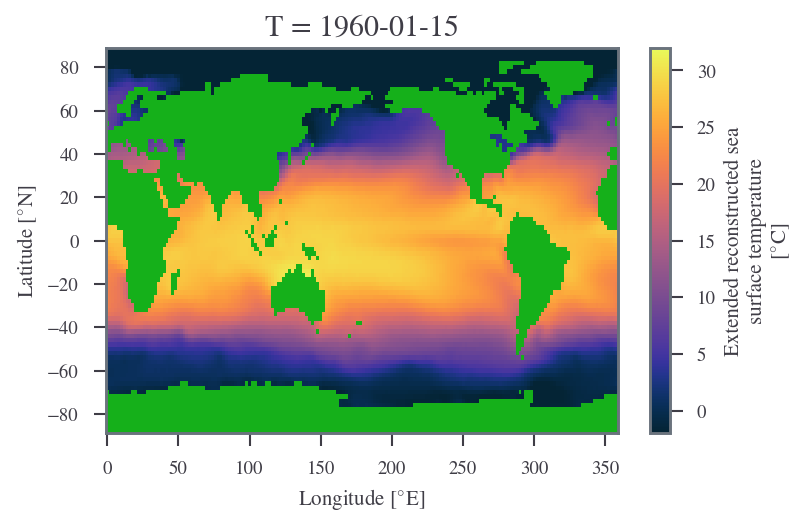

In [7]:
noaa_full = load_noaa_data()

noaa_full.isel(T=0).plot(cmap=cmap("sst"), vmin=-2, vmax=32)

In [26]:
len(noaa_full.coords["T"].values)

684

In [53]:
print(noaa_full.coords["T"].values[0])
print(noaa_full.coords["T"].values[-1])
# https://stackoverflow.com/questions/18215317/extracting-days-from-a-numpy-timedelta64-value
print((noaa_full.coords["T"].values[1]- noaa_full.coords["T"].values[0]).astype('timedelta64[D]'))

1960-01-15T00:00:00.000000000
2016-12-15T00:00:00.000000000
31 days


In [29]:
noaa_nino3_4_reg = sel(noaa_full, reg="nino3.4")

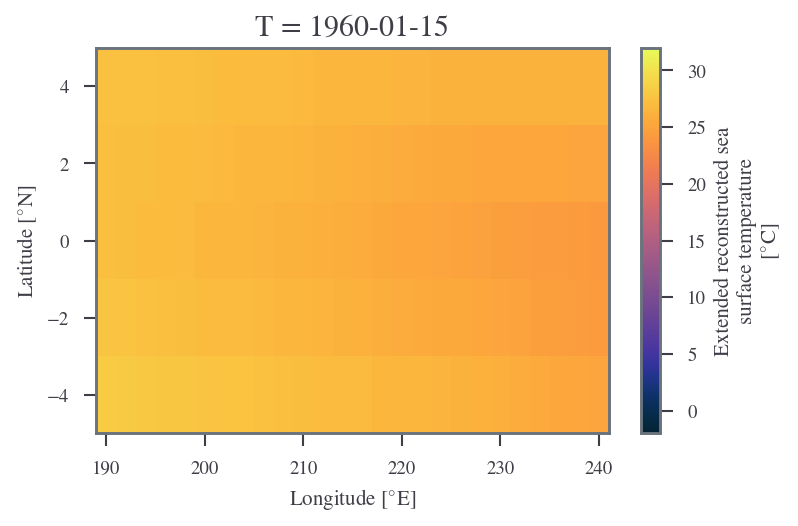

In [34]:
noaa_nino3_4_reg.isel(T=0).plot(cmap=cmap("sst"), vmin=-2, vmax=32)

In [4]:
# def get_region_of_interest(dset: xr.Dataset) -> xr.Dataset:
#     return dset.sel(lat=slice(-6, 6), lon=slice(190, 240))

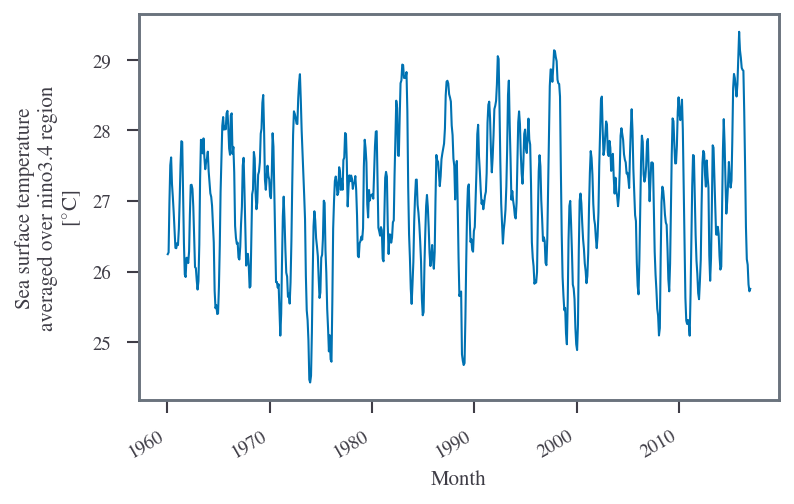

In [58]:
nino3_4_mean_timeseries = noaa_nino3_4_reg.mean(dim=["X", "Y"])
nino3_4_mean_timeseries.attrs["long_name"] = "Sea surface temperature averaged over nino3.4 region"
nino3_4_mean_timeseries.attrs["units"] = r"$^{\circ}$C"
nino3_4_mean_timeseries.coords["T"].attrs["long_name"] = "Month"
nino3_4_mean_timeseries.plot()

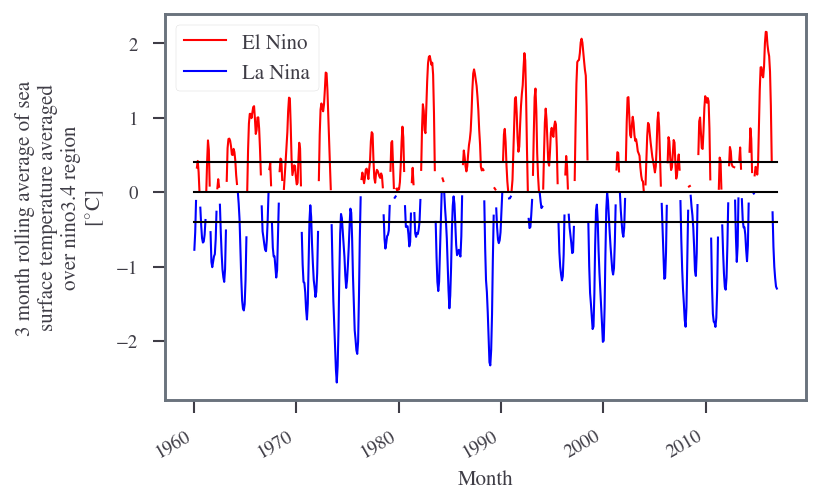

In [84]:
nino3_4_metric.where(nino3_4_metric>=0).plot(color="red", label="El Nino")
nino3_4_metric.where(nino3_4_metric<=0).plot(color="blue", label=r"La Nina")
dummy_line = nino3_4_metric.copy()
dummy_line[:] = 0
dummy_line.plot(color="black")
dummy_line[:] = 0.4
dummy_line.plot(color="black")
dummy_line[:] = -0.4
dummy_line.plot(color="black")
plt.legend()

In [90]:
from src.constants import NINO3_4_TEST_PATH

In [91]:
nino3_4_metric.to_netcdf(str(NINO3_4_TEST_PATH))

In [88]:
open_dataset(OCEAN_OUTPUT_PATH / "om_run2f.nc").SST_SST

<xarray.DataArray 'SST_SST' (T_03: 697, L_03: 1, Y_03: 161, X_03: 360)>
[40398120 values with dtype=float32]
Coordinates:
  * X_03     (X_03) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * Y_03     (Y_03) float32 -80.0 -79.0 -78.0 -77.0 ... 77.0 78.0 79.0 80.0
  * L_03     (L_03) float32 1.0
  * T_03     (T_03) object 1957-12-30 10:59:51.650391 ... 2015-12-28 16:53:33...
Attributes:
    long_name:  SST

In [19]:
print(open_dataset(OCEAN_OUTPUT_PATH / "om_spin.nc"))

<xarray.Dataset>
Dimensions:       (GRID: 1, L_01: 1, L_02: 1, L_03: 1, T_01: 241, T_02: 241, T_03: 241, X_01: 161, X_02: 360, X_03: 360, Y_01: 360, Y_02: 161, Y_03: 161)
Coordinates: (12/13)
  * GRID          (GRID) float32 0.0
  * X_01          (X_01) float32 -80.0 -79.0 -78.0 -77.0 ... 77.0 78.0 79.0 80.0
  * Y_01          (Y_01) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * L_01          (L_01) float32 1.0
  * T_01          (T_01) object 1937-12-30 10:59:31.875000 ... 1957-12-28 16:...
  * X_02          (X_02) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    ...            ...
  * L_02          (L_02) float32 0.0
  * T_02          (T_02) object 1937-12-30 10:59:31.875000 ... 1957-12-28 16:...
  * X_03          (X_03) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * Y_03          (Y_03) float32 -80.0 -79.0 -78.0 -77.0 ... 77.0 78.0 79.0 80.0
  * L_03          (L_03) float32 1.0
  * T_03          (T_03) object 1937-12-30 10:59:31.875000 ... 1957-12

## Compare different ninos

In [53]:
from src.metrics import nino_calculate

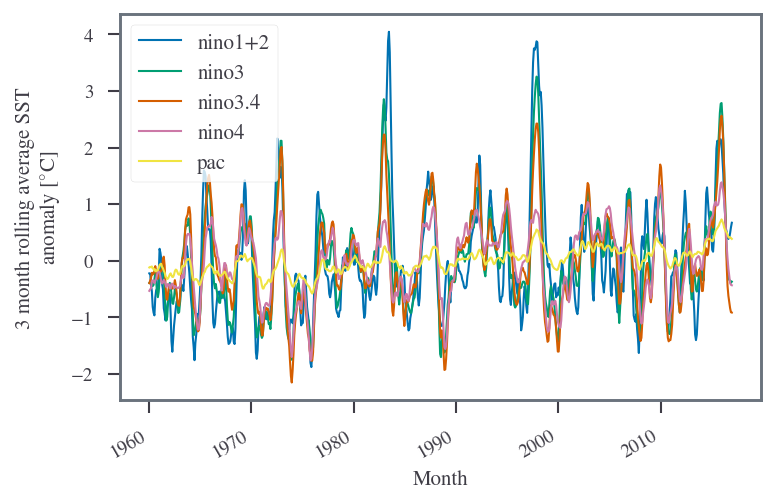

In [54]:
for reg in ["nino1+2", "nino3", "nino3.4", "nino4", "pac"]:
    metric, climatology = nino_calculate(noaa_full, reg=reg)
    metric.attrs["long_name"] = "3 month rolling average SST anomaly"
    metric.plot(label=metric.attrs["reg"])
    plt.legend()
    #print(reg, )

In [18]:
metric

<xarray.DataArray 'sst' (T: 684)>
array([-2.82265663e-01, -1.97355270e-01, -6.10891990e-02,  8.13528746e-02,
        8.75161514e-02,  2.19885521e-02, -1.35272980e-01, -1.91978455e-01,
       -2.46517822e-01, -2.24974319e-01, -2.56942123e-01, -2.76782990e-01,
       -2.36664459e-01, -1.47441864e-01, -1.30081177e-03,  7.43325576e-02,
        9.04254913e-02, -1.76277161e-02, -1.69327423e-01, -3.10485840e-01,
       -3.58098984e-01, -3.75059128e-01, -4.03191268e-01, -4.21957672e-01,
       -4.04160202e-01, -3.12211990e-01, -2.03395844e-01, -1.03411362e-01,
       -6.24949150e-02, -8.73832703e-02, -1.43710464e-01, -1.94041580e-01,
       -2.24223465e-01, -2.52489090e-01, -3.28693390e-01, -3.91384780e-01,
       -3.98534775e-01, -2.61179626e-01, -7.05788955e-02,  9.29133147e-02,
        1.25170395e-01,  6.29329681e-02, -2.52412166e-02, -4.49409485e-02,
       -4.81262207e-02, -2.37267818e-02, -6.52999878e-02, -1.10567734e-01,
       -1.82952881e-01, -2.02447891e-01, -1.63564056e-01, -1.27915069e-01,
       -1.24523163e-01, -1.76174805e-01, -2.83353180e-01, -3.60720962e-01,
       -3.99393737e-01, -4.10770416e-01, -4.95557159e-01, -5.76485336e-01,
       -5.59864044e-01, -4.33604568e-01, -2.42441177e-01, -7.90036544e-02,
        8.90477560e-03, -4.07816581e-02, -1.13838196e-01, -1.64288208e-01,
       -1.63787216e-01, -1.50176376e-01, -1.60561249e-01, -2.04169601e-01,
       -2.52628982e-01, -1.93823501e-01, -6.05290756e-02,  2.80927029e-02,
        9.90295410e-03, -7.06094131e-02, -1.56926483e-01, -2.18957275e-01,
...
       -1.16404854e-01, -1.44866943e-01, -2.05020905e-01, -2.83074707e-01,
       -2.83407867e-01, -1.88449860e-01,  4.00416087e-03,  1.79386139e-01,
        2.70706177e-01,  2.01371521e-01,  5.21170311e-02, -9.37169418e-02,
       -1.44111007e-01, -1.41295761e-01, -1.53243393e-01, -1.72547668e-01,
       -1.27707168e-01,  4.46891785e-03,  1.90095276e-01,  3.27623367e-01,
        3.60066116e-01,  2.83110321e-01,  1.27380371e-01,  5.32665253e-02,
        4.69741821e-02,  1.01352058e-01,  7.62430876e-02, -1.28320064e-02,
       -6.21795654e-02, -2.56525688e-02,  1.43927261e-01,  2.91238785e-01,
        3.45352173e-01,  2.76059479e-01,  1.67440414e-01,  1.20652519e-01,
        9.58932266e-02,  9.56134796e-02,  4.47235107e-02, -1.23634338e-02,
       -5.15855178e-02,  3.40372734e-02,  2.19802856e-01,  4.28108871e-01,
        5.35151839e-01,  5.07525802e-01,  4.11832184e-01,  3.44273269e-01,
        3.29783142e-01,  3.35697174e-01,  2.84478515e-01,  2.18288422e-01,
        1.80234283e-01,  2.64108032e-01,  4.56204742e-01,  6.47700667e-01,
        7.50356078e-01,  7.09217727e-01,  6.15572631e-01,  5.57757735e-01,
        5.63555419e-01,  6.17735565e-01,  6.08041167e-01,  5.84580123e-01,
        5.31923950e-01,  5.63275039e-01,  6.40003204e-01,  7.27488875e-01,
        7.44302750e-01,  6.56473160e-01,  5.02004623e-01,  3.81390274e-01,
        3.45212936e-01,  3.59710068e-01,  3.12082946e-01,  2.72651672e-01],
      dtype=float32)
Coordinates:
  * T        (T) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-11-15 2016-12-15
Attributes:
    long_name:        3 month rolling average SST anomaly
    units:            $^{\circ}$C
    reg:              pac
    rolling_average:  3 months
    mean_state:       26.015999

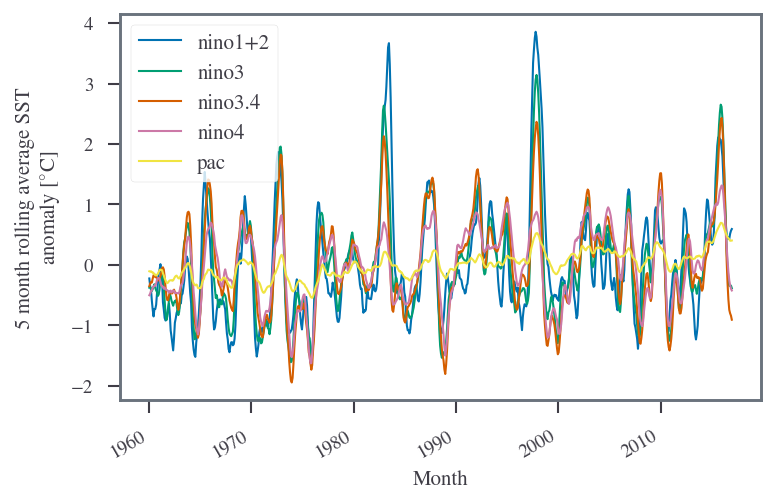

In [37]:
for reg in ["nino1+2", "nino3", "nino3.4", "nino4", "pac"]:
    metric, mean_state = nino_calculate(noaa_full, reg=reg, roll_period=5)
    metric.attrs["long_name"] = "5 month rolling average SST anomaly"
    metric.plot(label=metric.attrs["reg"])
    plt.legend()

## Compare with precip

In [21]:
# https://rabernat.github.io/research_computing_2018/assignment-8-xarray-for-enso.html

import pandas as pd
import xarray as xr
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.NASA/.GPCP/.V2p1/.multi-satellite/.prcp/dods'
dsp = xr.open_dataset(url, decode_times=False)
true_time = (pd.date_range(start='1960-01-01', periods=len(dsp['T']), freq='MS')
             +pd.Timedelta(days=14))
dsp['T'] = true_time
dsp.load()

<xarray.Dataset>
Dimensions:  (T: 354, X: 144, Y: 72)
Coordinates:
  * Y        (Y) float32 88.75 86.25 83.75 81.25 ... -81.25 -83.75 -86.25 -88.75
  * X        (X) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * T        (T) datetime64[ns] 1960-01-15 1960-02-15 ... 1989-05-15 1989-06-15
Data variables:
    prcp     (T, Y, X) float32 nan nan nan nan ... 0.06924 0.06633 0.06931 0.069
Attributes:
    Conventions:  IRIDL

In [52]:
time_coord = noaa_full.coords["T"].values
print(time_coord[0].__str__()[0:4] + " to "+ time_coord[-1].__str__()[0:4])

1960 to 2016


In [60]:
def mean_sst(sst_da: xr.DataArray) -> xr.DataArray:
    # Find mean temperature for each latitude
    mean_sst_lat = sst_da.mean(dim="X")

    # Find Weighted mean of those values
    # https://numpy.org/doc/stable/reference/generated/numpy.cos.html
    # https://numpy.org/doc/stable/reference/generated/numpy.radians.html
    num = (np.cos(np.radians(sst_da.Y)) * mean_sst_lat).sum(dim="Y")
    denom = np.sum(np.cos(np.radians(sst_da.Y)))

    # Find mean global temperature
        
    mean_temp = num / denom

    return mean_temp, np.cos(np.radians(sst_da.Y))

In [61]:
mean, cos = mean_sst(sel(noaa_full))

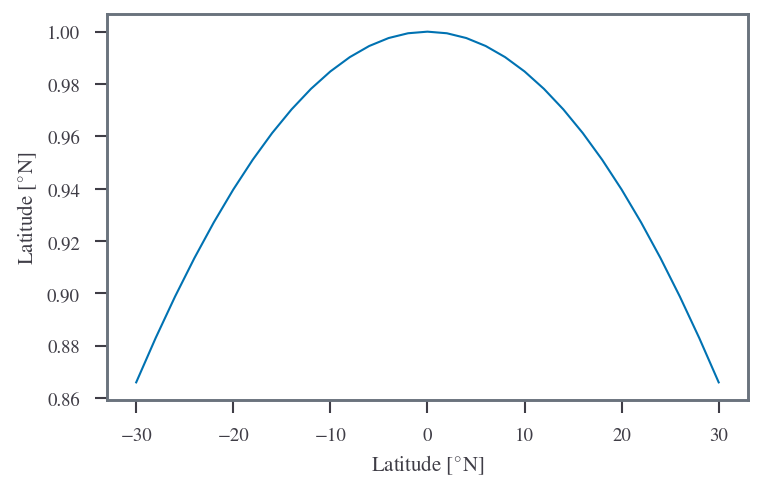

In [63]:
cos.plot()